In [1]:
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, BiphasicAxonMapSpatial, Model, AxonMapSpatial
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusII, ElectrodeArray

import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
os.environ["JAX_LOG_COMPILES"] = "True"
import jax.numpy as jnp
import jax
from jax import jit, vmap
jax.devices()

[GpuDevice(id=0, process_index=0)]

https://github.com/google/jax/issues/2521

## Where the magic happens (Jax predict_percept())

In [10]:
# NEW jax copy

def predict_one_segment(axon_segment, brights, sizes, streaks, x, y, rho, axlambda):
    d2_el = (axon_segment[0, None] - x)**2 + (axon_segment[1, None] - y)**2
    intensity = brights * jnp.exp(-d2_el / (2. * rho**2 * sizes)) * (axon_segment[2] ** 1./streaks)
    return jnp.sum(intensity)


# also vmap over simulated points
def predict_one_point(axon, brights, sizes, streaks, x, y, rho, axlambda):
#     d2_el = (axon[:, 0, None] - x)**2 + (axon[:, 1, None] - y)**2
#     intensities = brights * np.exp(-d2_el / (2. * rho**2 * sizes)) * (axon[:, 2, None] ** (1./streaks))
#     return jnp.max(np.sum(intensities, axis=1))
    intensities = jit(vmap(predict_one_segment, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6,7])(axon, brights, sizes, streaks, x, y, rho, axlambda)
    return jnp.max(intensities)
def gpu_biphasic_axon_map(params, # Per ACTIVE electrode, (amp, freq, pdur, x, y)
                          axon_segments, rho, axlambda, thresh_percept):
    deg2rad = 3.14159265358979323846 / 180.0

#     n_space = len(axon_segments)

    min_size = 10**2 / rho**2
    min_streak = 10**2 / axlambda **2

    # First get contributions from F, G, H per electrode
    scaled_amps = params[0] / (0.8825 + 0.27*params[2])
    brights = 1.84*scaled_amps + 0.2*params[1] + 2.0986
    sizes = jnp.maximum(1.081*scaled_amps - 0.3533764, min_size)
    streaks = jnp.maximum(1.56 - 0.54 * params[2] ** 0.21, min_streak)

    # axon_segments is (n_space, axon_length, 3), x and y are (n_elec)
    d2_el = (axon_segments[:, :, 0, None] - params[3])**2 + (axon_segments[:, :, 1, None] - params[4])**2
    # (n_space, axon_length, n_elecs)
    
    #                       (n_elecs) (n_space, axon_length, n_elecs)            (n_space, axon_length, n_elecs) 
    electrode_intensities = brights * jnp.exp(-d2_el / ( 2. * rho**2. * sizes)) * (axon_segments[:, :, 2, None] ** (1. / streaks))
    # (n_space, axon_length, n_elecs)
    
#     axon_intensities = 
    # (n_space, n_elecs)
    I = jnp.max(jnp.sum(electrode_intensities, axis=2), axis=1)
    
    
#     I = jit(vmap(predict_one_point, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6, 7])(axon_segments, brights, sizes, streaks, params[3], params[4], rho, axlambda)
#     I = (I > thresh_percept) * I
    return I



## Try again but this time push max operation to the end

In [2]:
# def predict_one_segment(axon_segment, brights, sizes, streaks, x, y, rho, axlambda):
#     d2_el = (axon_segment[0, None] - x)**2 + (axon_segment[1, None] - y)**2
#     intensity = brights * np.exp(-d2_el / (2. * rho**2 * sizes)) * (axon_segment[2] ** 1./streaks)
#     return np.sum(intensity)


# also vmap over simulated points
def predict_one_point(axon, brights, sizes, streaks, x, y, rho, axlambda):
    d2_el = (axon[:, 0, None] - x)**2 + (axon[:, 1, None] - y)**2
    intensities = brights * jnp.exp(-d2_el / (2. * rho**2 * sizes)) * (axon[:, 2, None] ** (1./streaks))
    return jnp.sum(intensities, axis=1)
#     return jit(vmap(predict_one_segment, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6,7])(axon, brights, sizes, streaks, x, y, rho, axlambda)

def gpu_biphasic_axon_map(amp, freq, pdur, x, y, # Per ACTIVE electrode, (amp, freq, pdur, x, y)
                          axon_segments, rho, axlambda, thresh_percept):
    deg2rad = 3.14159265358979323846 / 180.0

#     n_space = len(axon_segments)

    min_size = 10**2 / rho**2
    min_streak = 10**2 / axlambda **2

    # First get contributions from F, G, H per electrode
    scaled_amps = amp / (0.8825 + 0.27*pdur)
    brights = 1.84*scaled_amps + 0.2*freq + 3.0986
    sizes = jnp.maximum(1.081*scaled_amps - 0.3533764, min_size)
    streaks = jnp.maximum(1.56 - 0.54 * pdur ** 0.21, min_streak)

#     # axon_segments is (n_space, axon_length, 3), x and y are (n_elec)
#     d2_el = (axon_segments[:, :, 0, None] - params[3])**2 + (axon_segments[:, :, 1, None] - params[4])**2
#     # (n_space, axon_length, n_elecs)
    
#     #                       (n_elecs) (n_space, axon_length, n_elecs)            (n_space, axon_length, n_elecs) 
#     electrode_intensities = brights * jnp.exp(-d2_el / ( 2. * rho**2. * sizes)) * (axon_segments[:, :, 2, None] ** (1. / streaks))
#     # (n_space, axon_length, n_elecs)
    
# #     axon_intensities = 
#     # (n_space, n_elecs)
#     I = np.sum(electrode_intensities, axis=2)
    
    
    
    
    I = jnp.max(jit(vmap(predict_one_point, in_axes=[0, None, None, None, None, None, None, None]))(axon_segments, brights, sizes, streaks, x, y, rho, axlambda), axis=1)
    I = (I > thresh_percept) * I
    return I


#### Build model here in new spatial subclass, wrapped in BiphasicAxonMapGPU

In [14]:
import time
from copy import deepcopy
from pulse2percept.percepts import Percept
class BiphasicAxonMapGPUSpatial(AxonMapSpatial):
    def __init__(self, **params):
        super(BiphasicAxonMapGPUSpatial, self).__init__(**params)

    def _predict_spatial(self, earray, stim):
#         start = time.time()
        assert isinstance(earray, ElectrodeArray)
        assert isinstance(stim, Stimulus)

        # get relevant stimulus properties
        amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
        freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
        pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")

        x = np.array([earray[e].x for e in stim.electrodes], dtype=np.float32)
        y = np.array([earray[e].y for e in stim.electrodes], dtype=np.float32)
        
        params = np.vstack([amps, freqs, pdurs, x, y])
#         begin = time.time()
#         print("Setup time: %.3fms" % ((begin - start)*1000))
#         params = jax.device_put(params, jax.devices()[0])
#         ax_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])
#         ax_contrib = self.axon_contrib
#         e1 = time.time()
#         print("Transfer time: %.3fms" % ((e1 - begin)*1000))
        p =  jit(self.gpu_biphasic_axon_map, static_argnums=[6, 7, 8])(amps, freqs, pdurs, x, y,
                                     self.axon_contrib,
                                     self.rho, self.axlambda, self.thresh_percept)
#         end = time.time()
#         print("Jax time: {} ms on sample {}".format((end - begin) * 1000, stim.shape))

        return p

    def _build(self):
        super(BiphasicAxonMapGPUSpatial, self)._build()
        self.axon_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])
        
    def predict_one_point(self, axon, brights, sizes, streaks, x, y, rho, axlambda):
        d2_el = (axon[:, 0, None] - x)**2 + (axon[:, 1, None] - y)**2
        intensities = brights * jnp.exp(-d2_el / (2. * rho**2 * sizes)) * (axon[:, 2, None] ** (1./streaks))
        return jnp.sum(intensities, axis=1)
    #     return jit(vmap(predict_one_segment, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6,7])(axon, brights, sizes, streaks, x, y, rho, axlambda)

    def gpu_biphasic_axon_map(self, amp, freq, pdur, x, y, # Per ACTIVE electrode, (amp, freq, pdur, x, y)
                              axon_segments, rho, axlambda, thresh_percept):
        deg2rad = 3.14159265358979323846 / 180.0

    #     n_space = len(axon_segments)

        min_size = 10**2 / rho**2
        min_streak = 10**2 / axlambda **2

        # First get contributions from F, G, H per electrode
        scaled_amps = amp / (0.8825 + 0.27*pdur)
        brights = 1.84*scaled_amps + 0.2*freq + 3.0986
        sizes = jnp.maximum(1.081*scaled_amps - 0.3533764, min_size)
        streaks = jnp.maximum(1.56 - 0.54 * pdur ** 0.21, min_streak)

    #     # axon_segments is (n_space, axon_length, 3), x and y are (n_elec)
    #     d2_el = (axon_segments[:, :, 0, None] - params[3])**2 + (axon_segments[:, :, 1, None] - params[4])**2
    #     # (n_space, axon_length, n_elecs)

    #     #                       (n_elecs) (n_space, axon_length, n_elecs)            (n_space, axon_length, n_elecs) 
    #     electrode_intensities = brights * jnp.exp(-d2_el / ( 2. * rho**2. * sizes)) * (axon_segments[:, :, 2, None] ** (1. / streaks))
    #     # (n_space, axon_length, n_elecs)

    # #     axon_intensities = 
    #     # (n_space, n_elecs)
    #     I = np.sum(electrode_intensities, axis=2)




        I = jnp.max(jit(vmap(self.predict_one_point, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6, 7])(axon_segments, brights, sizes, streaks, x, y, rho, axlambda), axis=1)
    #     I = (I > thresh_percept) * I
        return I
        



class BiphasicAxonMapGPU(Model):
    def __init__(self, **params):
        super(BiphasicAxonMapGPU, self).__init__(spatial=BiphasicAxonMapGPUSpatial(), temporal=None, **params)

    def predict_percept(self, implant, t_percept=None):
#         start = time.time()
        # Make sure stimulus is a BiphasicPulseTrain:
        if not isinstance(implant.stim, BiphasicPulseTrain):
            # Could still be a stimulus where each electrode has a biphasic pulse train
            for ele, params in implant.stim.metadata['electrodes'].items():
                if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
                    raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
#         return super(BiphasicAxonMapGPU, self).predict_percept(implant, t_percept=t_percept)

        if not self.is_built:
            raise NotBuiltError("Yout must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))

        # Calculate the Stimulus at requested time points:

        stim = Stimulus(implant.stim) # make sure stimulus is in proper format

        e4 = time.time()
#         print("Stim restructuring and checks: %.3fms" % ((e4 - start) * 1000))
        
        resp = self._predict_spatial(implant.earray, stim)
        e5 = time.time()
        print("predict_spatial: %.3fms" % ((e5 - e4) * 1000))
        p = Percept(resp.reshape(list(self.grid.x.shape) + [-1]),
                       space=self.grid, time=None,
                       metadata={'stim': stim.metadata})
#         e6 = time.time()
#         print("Percept Construction: %.3fms" % ((e6 - e5) * 1000))
        return p

    def predict_percept_batched(self, implant, stim_list, t_percept=None):
        start = time.time()
        for stim in stim_list:
            if not isinstance(stim, BiphasicPulseTrain):
                # Could still be a stimulus where each electrode has a biphasic pulse train
                for ele, params in stim.metadata['electrodes'].items():
                    if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
                        raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
        if not self.is_built:
            raise NotBuiltError("You must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))
        
        batch = []
        for stim in stim_list:   
            amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
            freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
            pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")
            x = np.array([implant.earray[e].x for e in stim.electrodes], dtype=np.float32)
            y = np.array([implant.earray[e].y for e in stim.electrodes], dtype=np.float32)

            batch.append(np.vstack([amps, freqs, pdurs, x, y]))
        
        batch = np.array(batch) 
        e1 = time.time()
        print("Setup: %.3fms" % ((e1 - start) * 1000))
#         print(batch.shape)
        start = time.time()
#         print("Transfer: %.3fms" % ((start - e1) * 1000))
        resps = jit(vmap(gpu_biphasic_axon_map, in_axes=[0, None, None, None, None]), static_argnums=[2,3,4])(batch, self.axon_contrib, self.rho, self.axlambda, self.thresh_percept).block_until_ready()
        end = time.time()
        print("Jax time: %.3f ms, %.3f ms per sample" % (float(end - start) * 1000, float((end - start) * 1000 / len(stim_list))))

    

# Timing

In [15]:
model = BiphasicAxonMapGPU(axlambda=800, engine='jax', min_ax_sensitivity=5e-3)
model.build()
implant = ArgusII()
stim = Stimulus({"A2" : BiphasicPulseTrain(20, 1, 0.45), "A10" : BiphasicPulseTrain(30, 1, 0.45)})
implant.stim = stim

model_orig = BiphasicAxonMapModel(axlambda=800)
model_orig.build()
print()

In [16]:
stim = Stimulus({ "A10" : BiphasicPulseTrain(30, 1, 0.45)})
implant.stim = stim

In [125]:
stim = Stimulus({"A5" : BiphasicPulseTrain(20, 1, 0.45), "A10" : BiphasicPulseTrain(30, 1, 0.45), "A4" : BiphasicPulseTrain(20, 1, 0.45)})
implant.stim = stim

predict_spatial: 177.800ms
179.0618896484375


<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

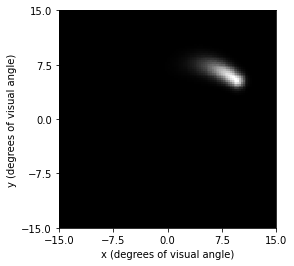

In [19]:
start = time.time()
percept = model.predict_percept(implant)
print((time.time() - start)*1000)
percept.plot()

<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

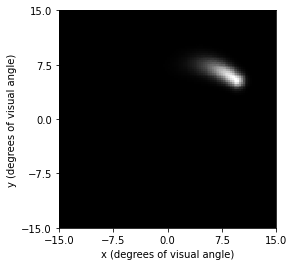

In [11]:
p1 = model_orig.predict_percept(implant)
p1.plot()

In [12]:
np.max(np.abs(p1.data - percept.data))

0.0188314039260149

In [19]:
import matplotlib.pyplot as plt

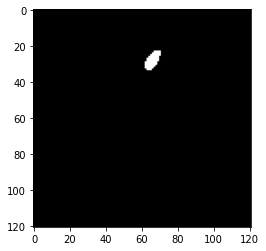

In [21]:
plt.imshow((np.abs(p1.data[:, :, 0] - percept.data[:, :, 0])) > 0.1, cmap='gray')

## Another sandbox copy


In [13]:
np.mean(p1.data - percept.data)

0.0002752206510624493

In [14]:
percept.get_brightest_frame().max()

10.825527

In [15]:
p1.get_brightest_frame().max()

10.827634811401367

## Timing

In [20]:
import time
import random
import math
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain

batch = None
batched_size = None
def rand_stim(implant, n_electrodes=1, shorten=True, verbose=True):
    maxamp = 15
    maxfreq = 200
    elecs = set()
    elecs.update(random.sample(list(implant.electrode_names), n_electrodes))
    
    stim = {}
    for elec in elecs:
        estim = None
        while estim is None:
            amp = random.random() * maxamp
            freq = random.random() * maxfreq
            pdur = random.expovariate(1)
            while pdur > 1000 / freq / 2 or pdur < 0.01 or pdur > 100:
                pdur = random.expovariate(1)
            
            try:
                if shorten:
                    estim = BiphasicPulseTrain(freq, amp, pdur, stim_dur=math.ceil(3*pdur))
                else:
                    estim = BiphasicPulseTrain(freq, amp, pdur, stim_dur=250)
            except Exception as e:
                if verbose: 
                    print("bad stim {}".format((freq, amp, pdur)))
                estim = None
                continue
        stim[elec] = estim
        
    stimulus = Stimulus(stim)
    return stimulus

def time_constant(model, implant, n_elecs=1, n_samples=10, stim_func=rand_stim, verbose=True, shorten=True):
    total_time = 0
    stim_time = 0
    for i in range(n_samples):
        try:
            start = time.time()
            stim = stim_func(implant, n_electrodes=n_elecs, shorten=shorten, verbose=verbose)
            implant.stim = stim
            stim_time += time.time() - start
            start = time.time()
            percept = model.predict_percept(implant)
            end = time.time()
#             print((end - start) * 1000)
            total_time += end - start
        except Exception as e:
            i -= 1
            print(e)
            continue
    if verbose:
        print("Average stimulus creation time: %.2fms" % (stim_time / n_samples * 1000))
        print("Average prediction time (%d electrodes): %.2fms" % (n_elecs, total_time / n_samples * 1000))
        print("Average prediction time per electrode: %.2fms" % (total_time / n_samples * 1000 / n_elecs))
    return total_time / n_samples * 1000

def time_batch(model, implant, n_elecs=1, batch_size=256, stim_func=rand_stim, verbose=True):
    global batch, batched_size
    if batch is None or batched_size != batch_size: # use precomputed batch if possible
        stim_list = []
        for i in range(batch_size):
            try:
                stim_list.append(stim_func(implant, n_electrodes=n_elecs))
            except Exception as e:
                i -= 1
                print(e)
                continue
        batch = stim_list
        batched_size = batch_size
    else:
        stim_list = batch
    
    print("predicting percepts")
    start = time.time()
    model.predict_percept_batched(implant, stim_list)
    end = time.time()
    total_time = end - start
    print("Average prediction time (%d electrodes): %.2fms" % (n_elecs, total_time / batch_size * 1000))
    print("Total batch time: %.3fs" % (end - start))
    return (end - start) / batch_size * 1000

In [23]:
print(model.axon_contrib.shape)

(14641, 102, 3)


In [22]:
# model = BiphasicAxonMapGPU(engine='jax')
# model.build()
# implant = ArgusII(rot=45)
time_constant(model, implant, n_elecs=1, n_samples=50)
time_constant(model, implant, n_elecs=15, n_samples=50)

predict_spatial: 279.127ms
predict_spatial: 166.567ms
predict_spatial: 170.034ms
predict_spatial: 168.227ms
predict_spatial: 164.964ms
predict_spatial: 172.937ms
predict_spatial: 172.008ms
predict_spatial: 167.841ms
predict_spatial: 182.189ms
predict_spatial: 186.288ms
predict_spatial: 168.850ms
predict_spatial: 167.004ms
predict_spatial: 172.615ms
predict_spatial: 163.858ms
predict_spatial: 169.128ms
predict_spatial: 171.149ms
predict_spatial: 171.918ms
predict_spatial: 170.310ms
predict_spatial: 168.442ms
predict_spatial: 166.584ms
predict_spatial: 166.658ms
predict_spatial: 170.053ms
predict_spatial: 194.618ms
predict_spatial: 172.002ms
predict_spatial: 172.694ms
predict_spatial: 164.962ms
predict_spatial: 171.270ms
predict_spatial: 172.128ms
predict_spatial: 171.420ms
predict_spatial: 172.719ms
predict_spatial: 169.031ms
predict_spatial: 166.097ms
predict_spatial: 168.579ms
predict_spatial: 174.219ms
predict_spatial: 174.172ms
predict_spatial: 165.146ms
predict_spatial: 166.725ms
p

141.3616418838501

In [13]:
# model = BiphasicAxonMapGPU(engine='jax')
# model.build()
# implant = ArgusII(rot=45)
time_batch(model, implant, n_elecs=15, batch_size=256)

predicting percepts
Setup: 23.847ms


TypeError: gpu_biphasic_axon_map() missing 4 required positional arguments: 'axon_segments', 'rho', 'axlambda', and 'thresh_percept'

In [9]:
jit(model_orig.size_model)(20, 1.24, 0.45)

ConcretizationTypeError: Abstract tracer value encountered where concrete value is expected: Traced<ShapedArray(bool[], weak_type=True)>with<DynamicJaxprTrace(level=0/1)>
The problem arose with the `bool` function. 
While tracing the function <unknown> for jit, this concrete value was not available in Python because it depends on the values of the arguments 'amp' and 'pdur'.

See https://jax.readthedocs.io/en/latest/errors.html#jax.errors.ConcretizationTypeError

'str' object cannot be interpreted as an integer
'str' object cannot be interpreted as an integer
'str' object cannot be interpreted as an integer
'str' object cannot be interpreted as an integer


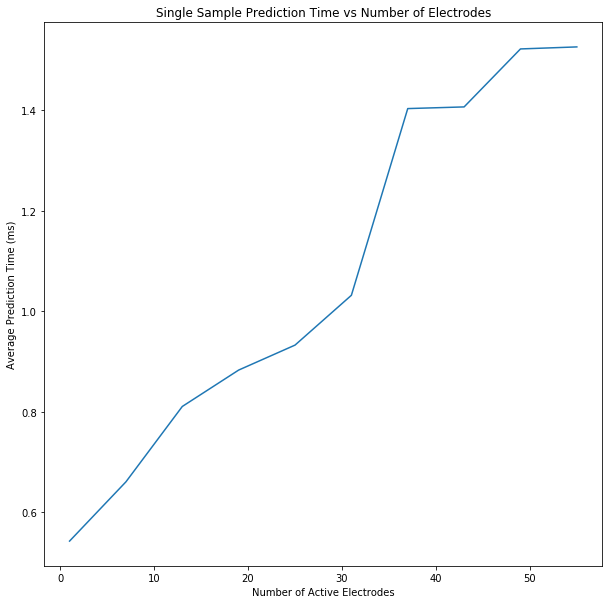

In [19]:
import matplotlib.pyplot as plt
n_elecs = np.arange(1, 60, 6)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times = []
model = BiphasicAxonMapGPU(axon_length=0.5)
model.build()
implant = ArgusII(rot=45)
time_constant(model, implant, n_samples=20, n_elecs=1, verbose=False)
for n_elec in n_elecs:
    times.append(time_constant(model, implant, n_samples=20, n_elecs=n_elec, verbose=False))
ax.plot(n_elecs, times)
ax.set_xlabel("Number of Active Electrodes")
ax.set_ylabel("Average Prediction Time (ms)")
ax.set_title("Single Sample Prediction Time vs Number of Electrodes")
    
fig.show()

predicting percepts
Setup: 22.231ms
Jax time: 146.331 ms, 0.576 ms per sample
Average prediction time (55 electrodes): 0.66ms
Total batch time: 0.169s
predicting percepts
Setup: 21.135ms
Jax time: 134.459 ms, 0.529 ms per sample
Average prediction time (1 electrodes): 0.61ms
Total batch time: 0.156s
predicting percepts
Setup: 21.260ms
Jax time: 135.989 ms, 0.535 ms per sample
Average prediction time (6 electrodes): 0.61ms
Total batch time: 0.157s
predicting percepts
Setup: 22.129ms
Jax time: 134.194 ms, 0.528 ms per sample
Average prediction time (11 electrodes): 0.61ms
Total batch time: 0.156s
predicting percepts
Setup: 21.993ms
Jax time: 134.743 ms, 0.530 ms per sample
Average prediction time (16 electrodes): 0.61ms
Total batch time: 0.157s
predicting percepts
Setup: 21.407ms
Jax time: 135.691 ms, 0.534 ms per sample
Average prediction time (21 electrodes): 0.61ms
Total batch time: 0.157s
predicting percepts
Setup: 21.801ms
Jax time: 133.465 ms, 0.525 ms per sample
Average prediction

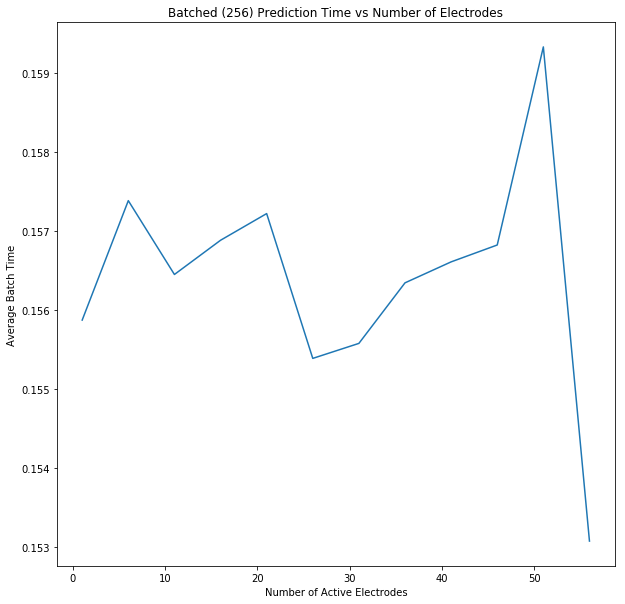

In [20]:
import matplotlib.pyplot as plt
n_elecs = np.arange(1, 60, 5)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times = []
model = BiphasicAxonMapGPU(axon_length=0.5)
model.build()
implant = ArgusII(rot=45)
time_batch(model, implant, batch_size=256, n_elecs=n_elec, verbose=False)
for n_elec in n_elecs:
    times.append(256 / 1000 * time_batch(model, implant, batch_size=256, n_elecs=n_elec, verbose=False))
ax.plot(n_elecs, times)
ax.set_xlabel("Number of Active Electrodes")
ax.set_ylabel("Average Batch Time")
ax.set_title("Batched (256) Prediction Time vs Number of Electrodes")
    
fig.show()

predicting percepts
Setup + transfer: 450.588ms
Jax time: 5.687 s, 22.304 ms per sample
Average prediction time (1 electrodes): 24.16ms
Total batch time: 6.184s
predicting percepts
Setup + transfer: 452.582ms
Jax time: 5.801 s, 22.748 ms per sample
Average prediction time (6 electrodes): 24.61ms
Total batch time: 6.301s
predicting percepts
Setup + transfer: 453.048ms
Jax time: 5.720 s, 22.431 ms per sample
Average prediction time (11 electrodes): 24.29ms
Total batch time: 6.219s
predicting percepts
Setup + transfer: 445.938ms
Jax time: 5.699 s, 22.349 ms per sample
Average prediction time (16 electrodes): 24.18ms
Total batch time: 6.191s
predicting percepts
Setup + transfer: 448.912ms
Jax time: 5.729 s, 22.468 ms per sample
Average prediction time (21 electrodes): 24.32ms
Total batch time: 6.225s
predicting percepts
Setup + transfer: 451.864ms
Jax time: 5.694 s, 22.331 ms per sample
Average prediction time (26 electrodes): 24.19ms
Total batch time: 6.192s
predicting percepts
Setup + tr

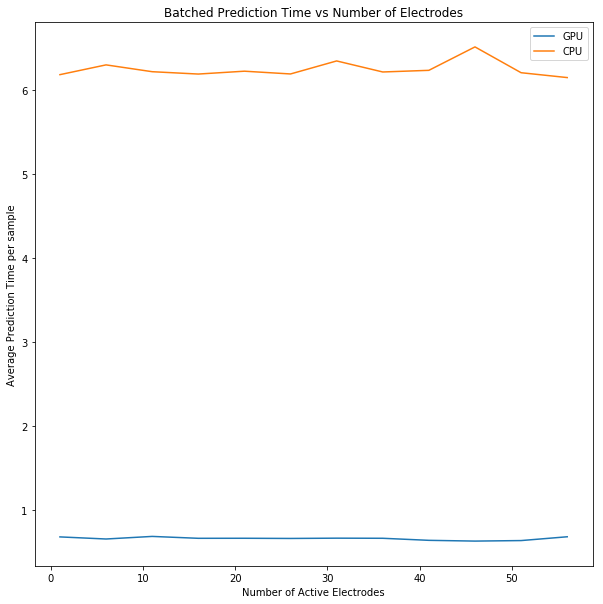

In [97]:
import matplotlib.pyplot as plt
n_elecs = np.arange(1, 60, 5)
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
times1 = []
model = BiphasicAxonMapGPU(axon_length=0.5)
model.build()
implant = ArgusII(rot=45)
for n_elec in n_elecs:
    times1.append(256 / 1000 * time_batch(model, implant, batch_size=256, n_elecs=n_elec, verbose=False))
ax.plot(n_elecs, times, label="GPU")
ax.plot(n_elecs, times1, label="CPU")
ax.set_xlabel("Number of Active Electrodes")
ax.set_ylabel("Average Prediction Time per sample")
ax.set_title("Batched Prediction Time vs Number of Electrodes")
ax.legend()
    
fig.show()

### Polyretina-scale 

In [14]:
from pulse2percept.implants import ElectrodeGrid, DiskElectrode, ProsthesisSystem

In [15]:
model = BiphasicAxonMapGPU(min_ax_sensitivity=9e-3, engine='jax')
model.build()

implant1 = ProsthesisSystem(ElectrodeGrid((100, 100), 120, r=40, names=('A', '1'), type='hex', etype=DiskElectrode))
implant2 = ProsthesisSystem(ElectrodeGrid((136, 136), 90, r=30, names=('A', '1'), type='hex', etype=DiskElectrode))
implant3 = ProsthesisSystem(ElectrodeGrid((200, 200), 60, r=20, names=('A', '1'), type='hex', etype=DiskElectrode))

In [7]:
# model = AxonMapGPU(axon_length=0.5)
# model.build()

AxonMapGPU(ax_segments_range=(0, 50), axlambda=200, 
           axon_length=0.5, axon_pickle='axons.pickle', 
           axons_range=(-180, 180), engine='serial', 
           eye='RE', grid_type='rectangular', 
           ignore_pickle=False, loc_od=(15.5, 1.5), 
           min_ax_sensitivity=0.001, n_ax_segments=500, 
           n_axons=1000, n_jobs=1, rho=200, 
           scheduler='threading', 
           spatial=AxonMapGPUSpatial, temporal=None, 
           thresh_percept=0, verbose=True, 
           xrange=(-15, 15), xystep=0.25, yrange=(-15, 15))

<AxesSubplot:xlabel='x (microns)', ylabel='y (microns)'>

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
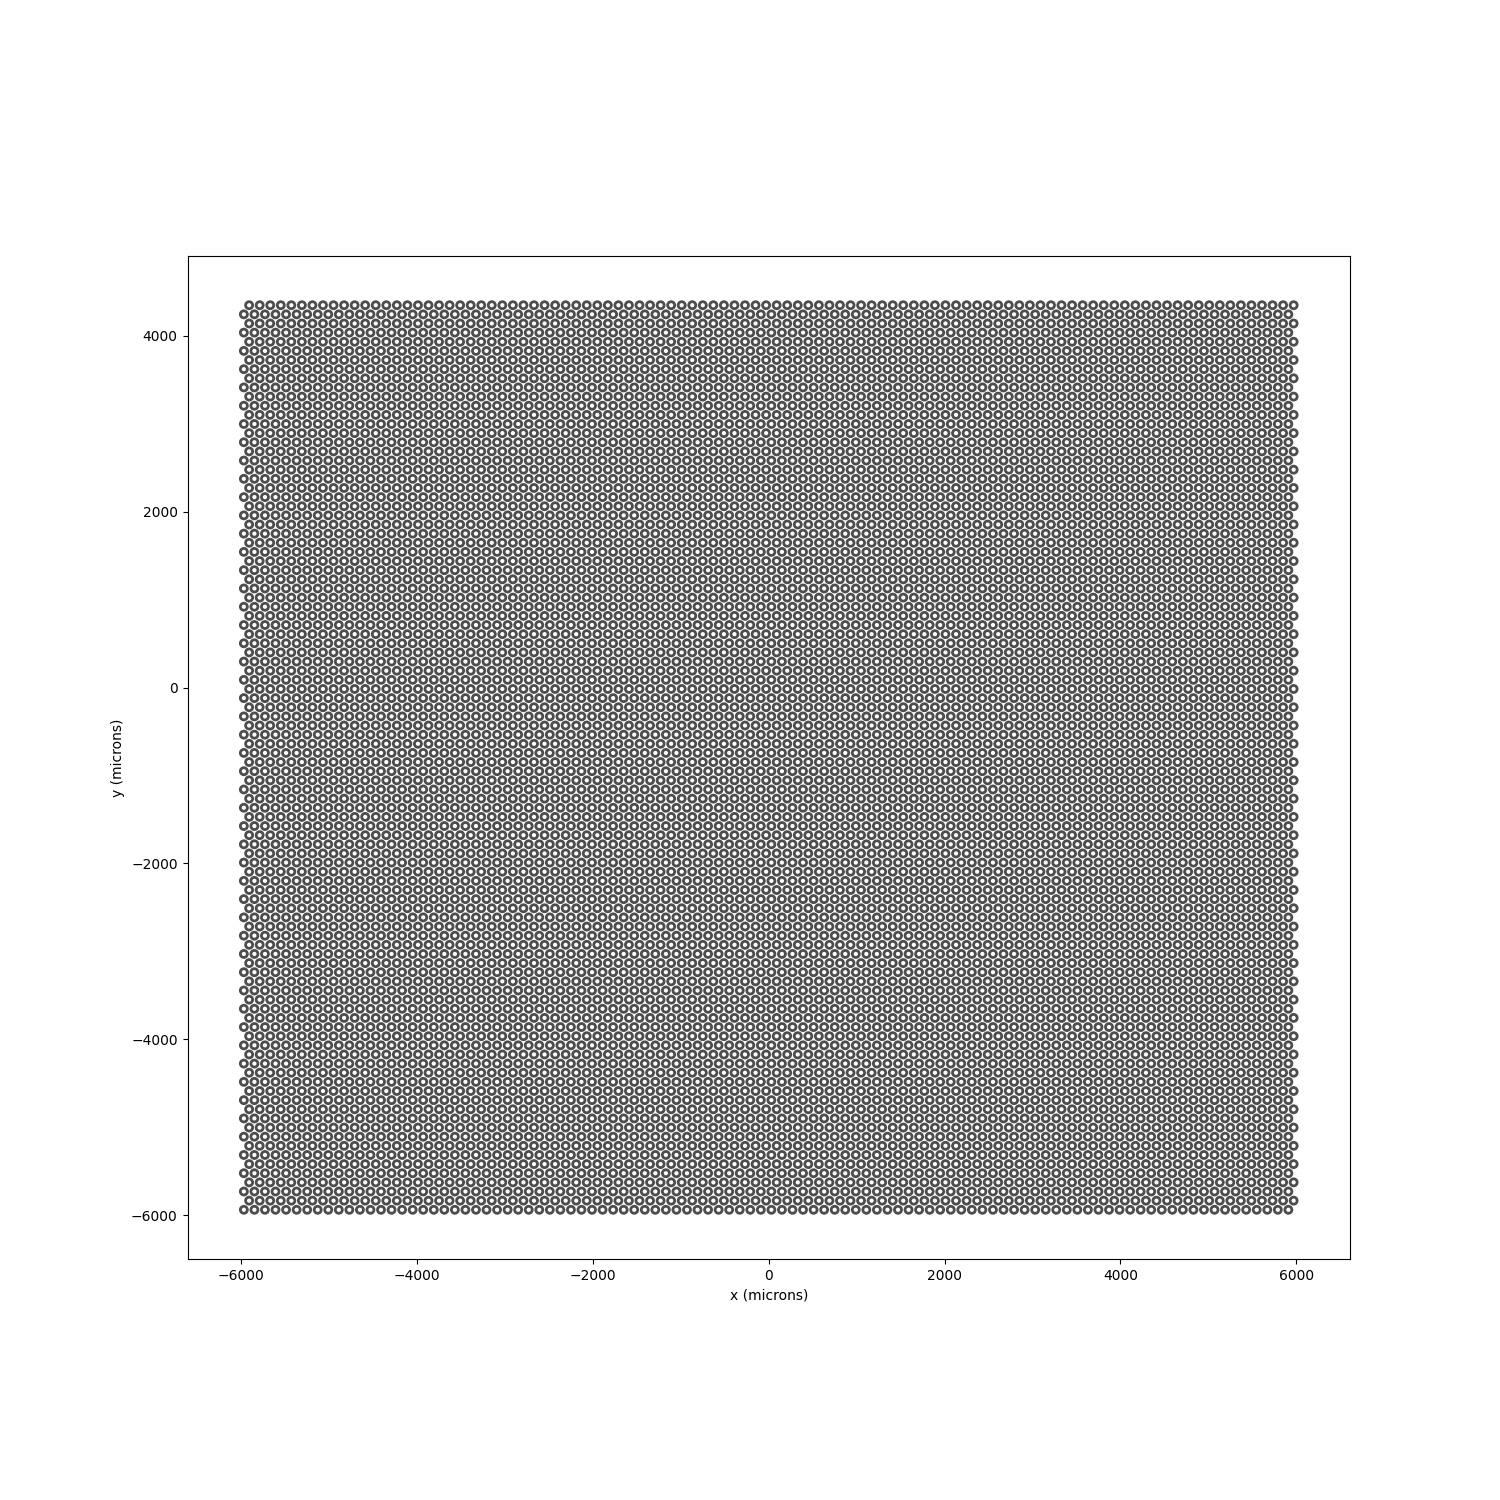

In [16]:
%matplotlib widget
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
implant1.plot()

In [99]:
stim = rand_stim(implant1, n_electrodes=100, shorten=False)
implant1.stim = stim

In [100]:
start = time.time()
model.predict_percept(implant1)
time.time() - start

0.2945520877838135

In [18]:
time_constant(model, implant2, n_elecs=2215, n_samples=20)

bad stim (181.89159146445516, 3.667125578479746, 2.5003997589286917)
bad stim (166.701459958215, 9.744416920232117, 1.9204157761805758)
bad stim (166.70040494441378, 0.6991683492105699, 1.990373372405644)
Average stimulus creation time: 439.97ms
Average prediction time (2215 electrodes): 1029.57ms
Average prediction time per electrode: 0.46ms


1029.5677781105042

In [27]:
time_constant(model, implant3, n_elecs=200*200, n_samples=20)

bad stim (82.20626289576467, 12.078812387179807, 5.835731080400242)
bad stim (111.12507926308473, 9.302760569077709, 2.7089002146990855)
bad stim (142.8682756935692, 3.620258149672223, 2.1622205329965496)
bad stim (166.67987499320193, 14.821853970928672, 1.9089406288724404)
bad stim (166.6797853617832, 9.624769143804972, 1.8220966137155266)
bad stim (76.93329644545881, 6.023229433062347, 4.225272342737013)
bad stim (100.01106579587193, 10.50060673399859, 3.2054202201262907)
bad stim (166.70200734616495, 2.5092408400425525, 1.6962475461813191)
bad stim (166.21567850414533, 5.8349372925083305, 2.983245346172902)
bad stim (166.66898011292318, 11.075671720194414, 1.7137643237739646)
bad stim (148.2383254032673, 10.606019108865038, 3.253174145442968)
bad stim (125.01831808283717, 13.705980160308414, 2.472289224974453)
bad stim (166.67139925880193, 9.635445829424643, 1.9371405887913984)
bad stim (142.87889611034112, 4.240003123991197, 2.22773833618067)
bad stim (164.618732206972, 0.942298099

575.7516622543335

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

AttributeError: Unknown property name

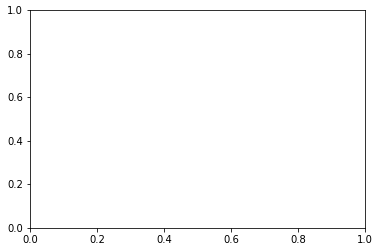

In [110]:
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
implants = [implant1, implant2, implant3]
model = BiphasicAxonMapGPU(axon_length=0.5)
model.build()

times = []
names = ['100x100', '136x136', '200x200']

for implant in implants:
    # run once to compile
    implant.stim = Stimulus({'A1' : BiphasicPulseTrain(20, 5, 0.45, stim_dur=10), 'CV10' : BiphasicPulseTrain(20, 5, 0.45, stim_dur=10)})
    model.predict_percept(implant)
    
    implant_times = []
    
    n_elecs = np.linspace(1, len(implant.electrodes), num=100)
    for n_elec in tqdm(n_elecs):
        implant_times.append(time_constant(model, implant, n_elecs=int(n_elec), n_samples=10, verbose=False, shorten=True))
    times.append([n_elecs, implant_times])

for i in range(len(implants)):
    plt.plot(times[i][0], times[i][1], label=names[i])

plt.xlabel("Number of Active Electrodes")
plt.ylabel("Average Prediction Time (ms)")
plt.title("Prediction Time vs Number of Electrodes")
plt.legend()
plt.show()

plt.savefig("BigImplants.png")
        
    

In [122]:
times[2][1][-5] = 588

In [123]:
len(times)

3

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

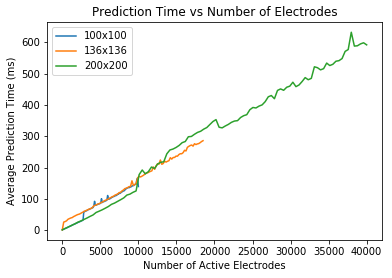

In [124]:
for i in range(len(implants)):
    plt.plot(times[i][0], times[i][1], label=names[i])

plt.xlabel("Number of Active Electrodes")
plt.ylabel("Average Prediction Time (ms)")
plt.title("Prediction Time vs Number of Electrodes")
plt.legend()
plt.show()

plt.savefig("BigImplants.png")
        

# Axon Map

In [1]:
from pulse2percept.models import AxonMapModel, BiphasicAxonMapModel, BiphasicAxonMapSpatial, Model, AxonMapSpatial
from pulse2percept.stimuli import Stimulus, BiphasicPulseTrain
from pulse2percept.implants import DiskElectrode, ProsthesisSystem, ArgusII, ElectrodeArray

import numpy as np
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import jax.numpy as jnp
import jax
from jax import jit, partial, vmap
jax.devices()

[GpuDevice(id=0, process_index=0)]

In [3]:
def predict_one_space_time(amp, d2_el, sensitivities, rho):
    #             (n_elec) (n_segments, n_elec) (n_segments) -> (n_segments, n_elec) -> (n_segments)
    return jnp.sum(amp * jnp.exp(-d2_el / (2. * rho**2)) * sensitivities[:, None], axis=1)


def predict_one_space(amps, xs, ys, axon, rho): # for every spatial point
    d2_el = (axon[:, 0, None] - xs)**2 + (axon[:, 1, None] - ys)**2
    # (n_segments, n_elec)
    return vmap(predict_one_space_time, in_axes=[1, None, None, None])(amps, d2_el, axon[:, 2], rho)
    # (n_time, n_segments)
def gpu_axon_map(amps, xs, ys, axons, rho, threshpercept):
    # amps is (n_elecs, n_time)
    
    I = vmap(predict_one_space, in_axes=[None, None, None, 0, None])(amps, xs, ys, axons, rho)
    # (n_space, n_time, n_segments)
    I = jnp.max(I, axis=2)
    return I  # Py overhead

In [4]:
import time
class AxonMapGPUSpatial(AxonMapSpatial):
    def __init__(self, **params):
        super(AxonMapGPUSpatial, self).__init__(**params)

    def _predict_spatial(self, earray, stim):
        start = time.time()
        assert isinstance(earray, ElectrodeArray)
        assert isinstance(stim, Stimulus)

        amps = stim.data

        xs = np.array([earray[e].x for e in stim.electrodes], dtype=np.float32)
        ys = np.array([earray[e].y for e in stim.electrodes], dtype=np.float32)
        e1 = time.time()
        print("Setup: %.3f ms" % ((e1 - start) * 1000))
        t = jit(gpu_axon_map, static_argnums=[4,5])(amps, xs, ys, self.axon_contrib, self.rho, self.thresh_percept)
        e2 = time.time()
        print("Jax: %.3f ms" % ((e2 - e1) * 1000))
        return t
        return gpu_axon_map(amps, xs, ys, self.axon_contrib, self.rho, self.thresh_percept)

    def _build(self):
        super(AxonMapGPUSpatial, self)._build()
        self.axon_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])



class AxonMapGPU(Model):
    def __init__(self, **params):
        super(AxonMapGPU, self).__init__(spatial=AxonMapGPUSpatial(), temporal=None, **params)

    def predict_percept_batched(self, implant, stim_list, t_percept=None):

        
        if not self.is_built:
            raise NotBuiltError("You must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))
        
        xs = [] #(n_elecs)
        ys = [] #(n_elecs)
        amps = [] #each entry is amp over time for each electrode for one percept (n_elecs, n_time)
        for stim in stim_list:
            implant.stim = stim
            # Make sure to operate on the compressed stim:
            if t_percept is None:
                t_percept = stim.time
            if not stim.is_compressed:
                stim.compress()
            n_time = 1 if t_percept is None else np.array([t_percept]).size
            if stim.data.size == 0:
                # Stimulus was compressed to zero:
                resp = np.zeros((self.grid.x.size, n_time), dtype=np.float32)
            else:
                # Calculate the Stimulus at requested time points:
                if t_percept is not None:
                    # Save electrode parameters
                    stim = Stimulus(stim) # make sure stimulus is in proper format
                    stim = Stimulus(stim[:, t_percept].reshape((-1, n_time)),
                                    electrodes=stim.electrodes, time=t_percept,
                                    metadata=stim.metadata)
                    
                
                xs.append(np.array([implant.earray[e].x for e in stim.electrodes], dtype=np.float32))
                ys.append(np.array([implant.earray[e].y for e in stim.electrodes], dtype=np.float32))
                
                amps.append(stim.data)
                 
#         print(batch.shape)
        resps = jit(vmap(gpu_axon_map, in_axes=[0, 0, 0, None, None, None, None]), static_argnums=[4,5])(amps, xs, ys, self.axon_contrib, self.rho, self.thresh_percept)
        
    

In [29]:
model = AxonMapGPU(axon_length=0.5, axlambda=800)
model.build()
implant = ArgusII()
stim = Stimulus({"A2" : BiphasicPulseTrain(20, 1, 0.45)})
implant.stim = stim

model_orig = AxonMapModel(axlambda=800)
model_orig.build()
print()

Setup: 0.036 ms
Jax: 4.082 ms
14.075756072998047


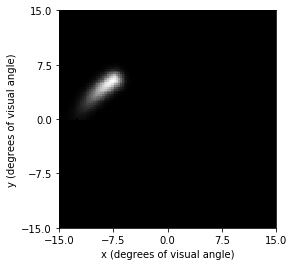

In [30]:
start = time.time()
percept = model.predict_percept(implant)
print((time.time() - start)*1000)
percept.plot()

257.53164291381836


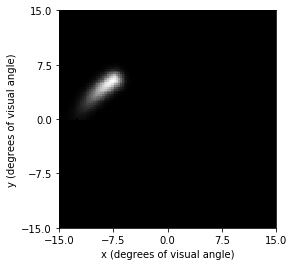

In [31]:
start = time.time()
p1 = model_orig.predict_percept(implant)
print((time.time() - start)*1000)
p1.plot()

In [38]:
np.argmax([np.max(percept.data[:, :, i] - p1.data[:, :, i]) for i in range(p1.data.shape[-1])])

1

In [33]:
np.mean(percept.data - p1.data)

0.0027005752

In [34]:
np.max(percept.data)

0.99725825

In [35]:
np.max(p1.data)

0.99725825

## Timing

In [47]:
from copy import deepcopy
import time
import random
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
# Cant use same approach as above because jax isnt freeing gpu memory
def get_stim(n_elec, implant):
    elecs = random.sample(implant.electrodes.keys(), n_elec)
    stim_dict = {elec:BiphasicPulseTrain(random.randrange(10, 50, 5), 1, 0.45) for elec in elecs}
    return Stimulus(stim_dict)


442.6143169403076


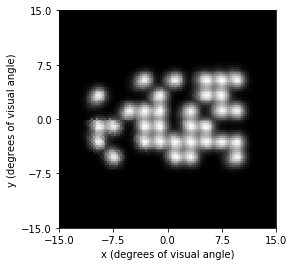

In [81]:

# implant.stim = get_stim(33, implant)
start = time.time()
p = model.predict_percept(implant)
end = time.time()
print((end - start) * 1000)
p.plot()

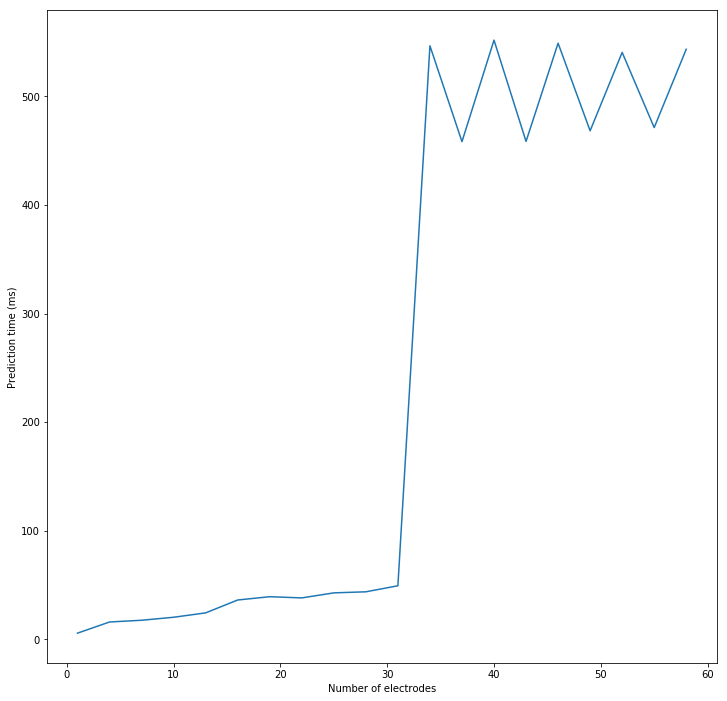

In [83]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 12))
model = AxonMapGPU(axon_length=0.5)
model.build()
times = []
for n_elec in np.arange(1, 60, 3):
    implant.stim = get_stim(n_elec, implant)
    model.predict_percept(implant)
    start = time.time()
    p = model.predict_percept(implant)
    end = time.time()
    times.append((end - start) * 1000)

plt.plot(np.arange(1, 60, 3), times)
plt.xlabel("Number of electrodes")
plt.ylabel("Prediction time (ms)")
plt.show()

## OLD

In [2]:
# numpy copy

def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments,
                          rho, axlambda, thresh_percept, timesteps):
  deg2rad = 3.14159265358979323846 / 180.0

  n_space = len(axon_segments)

  min_size = 10**2 / rho**2
  min_streak = 10**2 / axlambda **2

  # First get contributions from F, G, H per electrode
  scaled_amps = amps / (0.8825 + 0.27*pdurs)
  brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
  sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
  streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)

  I = np.zeros(shape=(n_space), dtype=np.float32)

  for idx_space in range(n_space):
    # (n_segments, n_elecs)
    d2_el = ((axon_segments[idx_space, :, 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_space, :, 1])[:, None] - y[None, :])**2. 

    # (n_segments, n_elecs)
    electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_space, :, 2])[:, None] ** (1. / streaks)[None, :])
    #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

    # (n_segments)
    axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

    axon_intensities[axon_intensities < thresh_percept] = 0.0

    I[idx_space] = np.max(axon_intensities)

  return np.asarray(np.transpose(np.tile(I, (timesteps, 1))))

In [ ]:
#OLD jax copy
"""
Function to be JIT'ed. 
Must be purely functional, and follow all rules at https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html

"""
def gpu_biphasic_axon_map(amps, freqs, pdurs, x, y, # Per ACTIVE electrode
                          axon_segments, rho, axlambda, thresh_percept, timesteps):
  deg2rad = 3.14159265358979323846 / 180.0

  n_space = len(axon_segments)

  min_size = 10**2 / rho**2
  min_streak = 10**2 / axlambda **2

  # First get contributions from F, G, H per electrode
  scaled_amps = amps / (0.8825 + 0.27*pdurs)
  brights = 1.84*scaled_amps + 0.2*freqs + 2.0986
  sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
  streaks = np.maximum(1.56 - 0.54 * pdurs ** 0.21, min_streak)

  I = np.zeros(shape=(n_space), dtype=np.float32)

  for idx_space in range(n_space):
    # (n_segments, n_elecs)
    d2_el = ((axon_segments[idx_space, :, 0])[:, None] - x[None, :])**2. + ((axon_segments[idx_space, :, 1])[:, None] - y[None, :])**2. 

    # (n_segments, n_elecs)
    electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * ((axon_segments[idx_space, :, 2])[:, None] ** (1. / streaks)[None, :])
    #                      (n_elec) * (n_segments, n_elecs)                  * (n_segments, n_elecs)

    # (n_segments)
    axon_intensities = np.sum(electrode_intensities, axis=1) # ith row is intensity at ith axon segment

    # axon_intensities = jax.ops.index_update(axon_intensities, (axon_intensities < thresh_percept), 0.0)

    I = jax.ops.index_update(I, idx_space, np.max(axon_intensities))
#     I[idx_space] = np.max(axon_intensities)

  return np.asarray(np.transpose(np.tile(I, (timesteps, 1))))


## Debug difference

In [156]:
""" Make another model but with numpy instead of Jax, see if its still different"""

import numpy as np
segs = []
def predict_one_point1(axon, brights, sizes, streaks, x, y, rho, axlambda):
    d2_el = (axon[:, 0, None] - x)**2 + (axon[:, 1, None] - y)**2
    intensities = brights * np.exp(-d2_el / (2. * rho**2 * sizes)) * (axon[:, 2, None] ** (1./streaks))
    return np.sum(intensities, axis=1)
#     return jit(vmap(predict_one_segment, in_axes=[0, None, None, None, None, None, None, None]), static_argnums=[6,7])(axon, brights, sizes, streaks, x, y, rho, axlambda)

def gpu_biphasic_axon_map1(params, # Per ACTIVE electrode, (amp, freq, pdur, x, y)
                          axon_segments, rho, axlambda, thresh_percept):
    deg2rad = 3.14159265358979323846 / 180.0

#     n_space = len(axon_segments)

    min_size = 10**2 / rho**2
    min_streak = 10**2 / axlambda **2

    # First get contributions from F, G, H per electrode
    scaled_amps = params[0] / (0.8825 + 0.27*params[2])
    brights = 1.84*scaled_amps + 0.2*params[1] + 3.0986
    sizes = np.maximum(1.081*scaled_amps - 0.3533764, min_size)
    streaks = np.maximum(1.56 - 0.54 * params[2] ** 0.21, min_streak)

#     # axon_segments is (n_space, axon_length, 3), x and y are (n_elec)
#     d2_el = (axon_segments[:, :, 0, None] - params[3])**2 + (axon_segments[:, :, 1, None] - params[4])**2
#     # (n_space, axon_length, n_elecs)
    
#     #                       (n_elecs) (n_space, axon_length, n_elecs)            (n_space, axon_length, n_elecs) 
#     electrode_intensities = brights * np.exp(-d2_el / ( 2. * rho**2. * sizes)) * (axon_segments[:, :, 2, None] ** (1. / streaks))
#     # (n_space, axon_length, n_elecs)
    
# #     axon_intensities = 
#     # (n_space, n_elecs)
#     I = np.sum(electrode_intensities, axis=2)
    
    
    print("len(axon_segments): " + str(len(axon_segments)))
    tmp = []
    for i in range(len(axon_segments)):
        t = predict_one_point(axon_segments[i], brights, sizes, streaks, params[3], params[4], rho, axlambda)
        tmp.append(t)
        if i == 40*121 + 50:
            print(axon_segments[40*121 + 50][12])
            print(t[12])
            print(t)
            
            print(brights)
            print(sizes)
            print(streaks)
            print(params[3])
            print(params[4])
            print(rho)
            print(axlambda)
        
    I = np.max(tmp, axis=1)
#     I = (I > thresh_percept) * I
    return I




In [157]:
import time
from copy import deepcopy
from pulse2percept.percepts import Percept
class BiphasicAxonMapGPUSpatial1(AxonMapSpatial):
    def __init__(self, **params):
        super(BiphasicAxonMapGPUSpatial1, self).__init__(**params)

    def _predict_spatial(self, earray, stim):
#         start = time.time()
        assert isinstance(earray, ElectrodeArray)
        assert isinstance(stim, Stimulus)

        # get relevant stimulus properties
        amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
        freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
        pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")

        x = np.array([earray[e].x for e in stim.electrodes], dtype=np.float32)
        y = np.array([earray[e].y for e in stim.electrodes], dtype=np.float32)
        
        params = np.vstack([amps, freqs, pdurs, x, y])
#         begin = time.time()
#         print("Setup time: %.3fms" % ((begin - start)*1000))
#         params = jax.device_put(params, jax.devices()[0])
#         ax_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])
#         ax_contrib = self.axon_contrib
#         e1 = time.time()
#         print("Transfer time: %.3fms" % ((e1 - begin)*1000))
        p = gpu_biphasic_axon_map1(params, self.axon_contrib, self.rho, self.axlambda, self.thresh_percept)
#         end = time.time()
#         print("Jax time: {} ms on sample {}".format((end - begin) * 1000, stim.shape))

        return p

    def _build(self):
        super(BiphasicAxonMapGPUSpatial1, self)._build()
#         self.axon_contrib = jax.device_put(self.axon_contrib, jax.devices()[0])
        
        



class BiphasicAxonMapGPU1(Model):
    def __init__(self, **params):
        super(BiphasicAxonMapGPU1, self).__init__(spatial=BiphasicAxonMapGPUSpatial1(), temporal=None, **params)

    def predict_percept(self, implant, t_percept=None):
#         start = time.time()
        # Make sure stimulus is a BiphasicPulseTrain:
        if not isinstance(implant.stim, BiphasicPulseTrain):
            # Could still be a stimulus where each electrode has a biphasic pulse train
            for ele, params in implant.stim.metadata['electrodes'].items():
                if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
                    raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
#         return super(BiphasicAxonMapGPU, self).predict_percept(implant, t_percept=t_percept)

        if not self.is_built:
            raise NotBuiltError("Yout must call ``build`` first.")
        if not isinstance(implant, ProsthesisSystem):
            raise TypeError(("'implant' must be a ProsthesisSystem object, "
                             "not %s.") % type(implant))

        # Calculate the Stimulus at requested time points:

        stim = Stimulus(implant.stim) # make sure stimulus is in proper format

#         e4 = time.time()
#         print("Stim restructuring and checks: %.3fms" % ((e4 - start) * 1000))
        
        resp = self._predict_spatial(implant.earray, stim)
#         e5 = time.time()
#         print("predict_spatial: %.3fms" % ((e5 - e4) * 1000))
        p = Percept(resp.reshape(list(self.grid.x.shape) + [-1]),
                       space=self.grid, time=None,
                       metadata={'stim': stim.metadata})
#         e6 = time.time()
#         print("Percept Construction: %.3fms" % ((e6 - e5) * 1000))
        return p

#     def predict_percept_batched(self, implant, stim_list, t_percept=None):
#         start = time.time()
#         for stim in stim_list:
#             if not isinstance(stim, BiphasicPulseTrain):
#                 # Could still be a stimulus where each electrode has a biphasic pulse train
#                 for ele, params in stim.metadata['electrodes'].items():
#                     if params['type'] != BiphasicPulseTrain or params['metadata']['delay_dur'] != 0: 
#                         raise TypeError("All stimuli must be BiphasicPulseTrains with no delay dur (Failing electrode: %s)" % (ele)) 
        
#         if not self.is_built:
#             raise NotBuiltError("You must call ``build`` first.")
#         if not isinstance(implant, ProsthesisSystem):
#             raise TypeError(("'implant' must be a ProsthesisSystem object, "
#                              "not %s.") % type(implant))
        
#         batch = []
#         for stim in stim_list:   
#             amps = np.array([stim.metadata['electrodes'][str(e)]['metadata']['amp'] for e in stim.electrodes], dtype="float32")
#             freqs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['freq'] for e in stim.electrodes], dtype="float32")
#             pdurs = np.array([stim.metadata['electrodes'][str(e)]['metadata']['phase_dur'] for e in stim.electrodes], dtype="float32")
#             x = np.array([implant.earray[e].x for e in stim.electrodes], dtype=np.float32)
#             y = np.array([implant.earray[e].y for e in stim.electrodes], dtype=np.float32)

#             batch.append(np.vstack([amps, freqs, pdurs, x, y]))
        
#         batch = np.array(batch) 
#         e1 = time.time()
#         print("Setup: %.3fms" % ((e1 - start) * 1000))
# #         print(batch.shape)
#         start = time.time()
# #         print("Transfer: %.3fms" % ((start - e1) * 1000))
#         resps = jit(vmap(gpu_biphasic_axon_map, in_axes=[0, None, None, None, None]), static_argnums=[2,3,4])(batch, self.axon_contrib, self.rho, self.axlambda, self.thresh_percept).block_until_ready()
#         end = time.time()
#         print("Jax time: %.3f ms, %.3f ms per sample" % (float(end - start) * 1000, float((end - start) * 1000 / len(stim_list))))

    

In [158]:
from pulse2percept.models import BiphasicAxonMapModel
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.implants import ArgusII

In [159]:
model_np = BiphasicAxonMapGPU1(axlambda=800)
model_np.build()

model = BiphasicAxonMapGPU(axlambda=800)
model.build()

model_orig = BiphasicAxonMapModel(axlambda=800)
model_orig.build()
print()

In [187]:
implant = ArgusII()
stim = Stimulus({"A5" : BiphasicPulseTrain(20, 1, 0.45), "A10" : BiphasicPulseTrain(30, 1, 0.45), "A4" : BiphasicPulseTrain(20, 1, 0.45), "A7" : BiphasicPulseTrain(30, 1, 0.45)})
implant.stim = stim

len(axon_segments): 14641
[-3.084e+02 -1.484e+03  8.732e-01]
7.5900545
[5.094e+00 4.640e+00 4.284e+00 ... 8.024e-04 8.024e-04 8.024e-04]
[ 8.931 10.931  8.931 10.931]
[0.723 0.723 0.723 0.723]
[1.103 1.103 1.103 1.103]
[-287.5 2587.5 -862.5  862.5]
[-1437.5 -1437.5 -1437.5 -1437.5]
200
800


<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

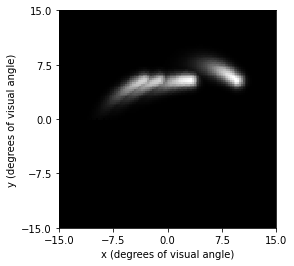

In [188]:
p_np = model_np.predict_percept(implant)
p_np.plot()

In [189]:
print(f_bright)
print(f_size)
print(f_streak)


8.931269322709163
0.7235567169729271
1.1033658499482901


(array([-287.5, 2587.5, -862.5,  862.5], dtype=float32), array([-1437.5, -1437.5, -1437.5, -1437.5], dtype=float32))


<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

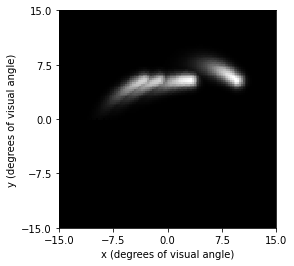

In [190]:
p_orig = model_orig.predict_percept(implant)
p_orig.plot()

<AxesSubplot:xlabel='x (degrees of visual angle)', ylabel='y (degrees of visual angle)'>

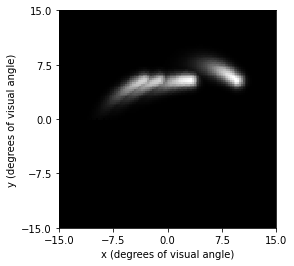

In [191]:
p = model.predict_percept(implant)
p.plot()

In [192]:
model_np.axon_contrib[pixel_idx]

array([[-6.869e+02, -1.350e+03,  9.998e-01],
       [-6.553e+02, -1.363e+03,  9.981e-01],
       [-6.237e+02, -1.375e+03,  9.946e-01],
       ...,
       [ 2.171e+03, -1.303e+03,  1.054e-03],
       [ 2.171e+03, -1.303e+03,  1.054e-03],
       [ 2.171e+03, -1.303e+03,  1.054e-03]], dtype=float32)

In [193]:
model_orig.axon_contrib[pixel_idx]

array([[-6.869e+02, -1.350e+03,  9.998e-01],
       [-6.553e+02, -1.363e+03,  9.981e-01],
       [-6.237e+02, -1.375e+03,  9.946e-01],
       ...,
       [ 2.171e+03, -1.303e+03,  1.054e-03],
       [ 2.171e+03, -1.303e+03,  1.054e-03],
       [ 2.171e+03, -1.303e+03,  1.054e-03]], dtype=float32)

### Difference between gpu and original

In [194]:
import matplotlib.pyplot as plt

In [200]:
np.max(np.abs(p.data[:, :, :] - p_orig.data[:, :, :]))

0.0016741753

In [196]:
np.mean(np.abs(p.data[:, :, 0] - p_orig.data[:, :, 0]))

5.1693838e-05

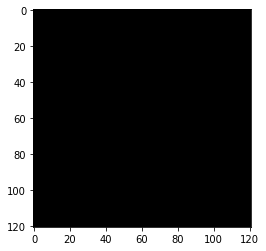

In [199]:
plt.imshow(np.abs(p.data[:, :, 0] - p_orig.data[:, :, 0]) > 0.4, cmap='gray')

#### Difference between gpu and numpy

In [198]:
np.max(np.abs(p.data[:, :, 0] - p_np.data[:, :, 0]))

1.9073486e-06

In [172]:
np.mean(np.abs(p.data[:, :, 0] - p_np.data[:, :, 0]))

1.0758484e-08

No difference

#### Investigate at percept(40, 50)

In [173]:
p.data[40, 50, 0]

7.552312

In [174]:
p_orig.data[40, 50, 0]

7.552423

In [175]:
xyret = np.column_stack((model.grid.xret.ravel(), model.grid.yret.ravel()))

In [176]:
pixel_idx = 40*121 + 50
xyret[pixel_idx]

array([ -672.012, -1347.526], dtype=float32)

In [177]:
x_elec = implant.earray['A5'].x
y_elec = implant.earray['A5'].y

In [178]:
axon_orig = model_orig.axon_contrib[pixel_idx]
axon_new = model.axon_contrib[pixel_idx]

In [179]:
np.sum(axon_orig != axon_new)

DeviceArray(0, dtype=int32)

In [180]:
axon = axon_orig

In [181]:
axon.shape

(116, 3)

In [182]:
model.rho

200

In [183]:
seg_bright = np.zeros(116)
d2els = []
for i in range(116):
    f_bright = model_orig.bright_model(1, 20, 0.45)
    f_size = model_orig.size_model(1, 20, 0.45)
    f_streak = model_orig.streak_model(1, 20, 0.45)
    seg_x, seg_y, sens = axon[i, :]
    d2el = (seg_x - x_elec)**2 + (seg_y - y_elec)**2
    d2els.append(d2el)
    seg_bright[i] = f_bright * np.exp(- d2el / (2 * (200*200 * f_size))) * (sens**(1/f_streak))

In [184]:
np.max(seg_bright)

7.552423670411401

In [185]:
np.argmax(seg_bright)

12

In [186]:
f_bright

8.931269322709163

## Jit Effects Models

In [85]:
from typing import Type
import numpy as np
import sys

from pulse2percept.models import AxonMapModel, AxonMapSpatial, TemporalModel, Model
from pulse2percept.implants import ProsthesisSystem, ElectrodeArray
from pulse2percept.stimuli import BiphasicPulseTrain, Stimulus
from pulse2percept.percepts import Percept
from pulse2percept.utils import FreezeError
from pulse2percept.models import BaseModel, NotBuiltError


class DefaultSizeModel(BaseModel):
    """
    Default model to be used for size (rho) scaling in BiphasicAxonMapModel
    Implements Eq 5 from [Granley2021]_ 
    Fit using data from [Nanduri2012]_ and [Weitz2015]_

    Parameters:
    ------------
    rho :  float32
        Rho parameter of BiphasicAxonMapModel (spatial decay rate)
    a0, a1 : float, optional
        Linear regression coefficients (slope and intercept) of pulse_duration
        vs threshold curve (Eq 3). Amplitude factor will be scaled by 
        (a0*pdur + a1)^-1.
    a5, a6 : float, optional
        Linear regression coefficients for size vs amplitude (Eq 5)
        F_size = a5*scaled_amp + a6 
    """

    def __init__(self, rho, **params):
        super(DefaultSizeModel, self).__init__(**params)
        self.rho = rho
        self.engine = 'jax'
        self.build()

    def get_default_params(self):
        params = {
            'a0': 2.095,
            'a1': 0.054326,
            'a5': 1.0812,
            'a6': -0.35338,
            # dont let rho be scaled below this threshold
            'min_rho': 10,
        }
        return params

    def scale_threshold(self, pdur):
        """ 
        Based on eq 3 in paper, this function produces the factor that amplitude
        will be scaled by to produce a_tilde. Computes A_0 * t + A_1 (1/threshold)
        """
        return self.a1 + self.a0*pdur

    def __call__(self, freq, amp, pdur):
        """
        Main function to be called by BiphasicAxonMapModel
        Outputs value for each electrode that rho should be scaled by (F_size)
        """
        min_f_size = self.min_rho**2 / self.rho**2
        F_size = self.a5 * amp * self.scale_threshold(pdur) + self.a6
        if self.engine == 'jax':
            return jnp.maximum(F_size, min_f_size)
        else:
            return max(400, min_f_size)

In [107]:
t = DefaultSizeModel(200)

In [110]:
f = jit(t)

In [111]:
f(20, 1.25, 0.45)

DeviceArray(400, dtype=int32)

In [78]:
def f(x):
    return jnp.maximum(x, 4)

In [79]:
jit(f)(3)

DeviceArray(4, dtype=int32)

In [108]:
t.engine = "sdf"

In [109]:
t.engine

'sdf'